# **1. Limit of the multi-percentron (MLP) neural networks (created only by "nn.linear')**

In [1]:
import torchvision
data_folder = '/root/'
fmnist = torchvision.datasets.FashionMNIST(data_folder,train=True,download=True)
trn_images = fmnist.data
trn_targets = fmnist.targets

val_fmnist = torchvision.datasets.FashionMNIST(data_folder,train=False,download=True)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/FashionMNIST/raw



In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class FMNISTds(Dataset):
  def __init__(self,x,y):
    x = x.float()
    x = x.view(-1,28*28)/255
    self.x, self.y = x, y
  def __len__(self): return len(self.x)
  def __getitem__(self,ix):
    x = self.x[ix]
    y = self.y[ix]
    return x.to(device), y.to(device)

def get_data():
  trn = FMNISTds(trn_images,trn_targets)
  trn_dl = DataLoader(trn,batch_size=32,shuffle=True,drop_last=True)

  val = FMNISTds(val_images,val_targets)
  val_dl = DataLoader(val,batch_size=len(val_images),shuffle=True)

  return trn_dl, val_dl

trn_dl, val_dl = get_data()

In [4]:
def get_model():
  model = nn.Sequential(
      nn.Linear(28*28,1000),
      nn.ReLU(),
      nn.Linear(1000,1000),
      nn.ReLU(),
      nn.Linear(1000,10)
  ).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
  return model, loss_fn, optimizer

def train_batch(x,y,model,loss_fn,optimizer):
  model.train()
  prediction = model(x)
  loss = loss_fn(prediction,y)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return loss.item()

@torch.no_grad()
def accuracy(x,y,model):
  model.eval()
  prediction = model(x)
  max_vals, argmaxes = prediction.max(-1)
  acc = argmaxes == y
  return acc.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x,y,model,loss_fn):
  prediction = model(x)
  val_loss = loss_fn(prediction,y)
  return val_loss.item()

model, loss_fn, optimizer = get_model()

In [5]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       patience=0,factor=0.5,
                                                       threshold=0.001,
                                                       verbose=True,
                                                       min_lr=1e-5,
                                                       threshold_mode='abs')
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
  print (f'{epoch+1}/10 in progress')
  train_epoch_losses, train_epoch_accuracies =[] ,[]
  val_epoch_losses, val_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x,y,model,loss_fn,optimizer)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    trn_acc = accuracy(x,y,model)
    train_epoch_accuracies.extend(trn_acc)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    validation_loss = val_loss(x,y,model,loss_fn)
    val_acc = accuracy(x,y,model)
    scheduler.step(validation_loss)
  val_epoch_accuracy = np.mean(val_acc)
  
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)

1/10 in progress
2/10 in progress
3/10 in progress
4/10 in progress
5/10 in progress
Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
6/10 in progress
Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
7/10 in progress
8/10 in progress
Epoch 00008: reducing learning rate of group 0 to 1.2500e-04.
9/10 in progress
Epoch 00009: reducing learning rate of group 0 to 6.2500e-05.
10/10 in progress
Epoch 00010: reducing learning rate of group 0 to 3.1250e-05.


3. Accuracy Test (Case 1: When an image is translated)

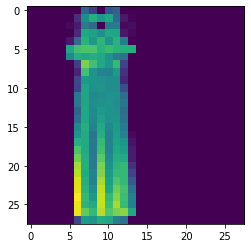

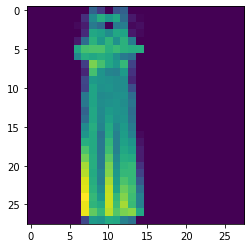

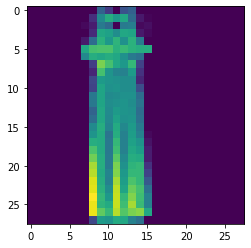

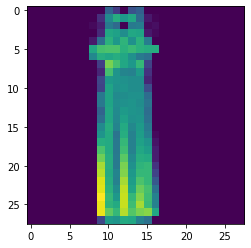

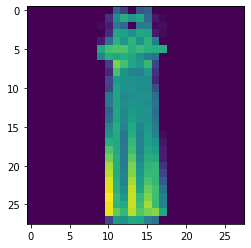

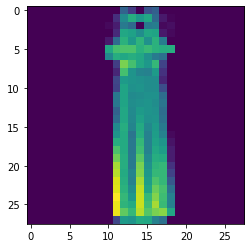

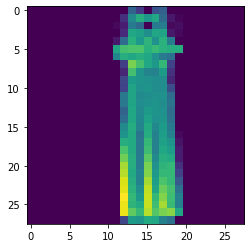

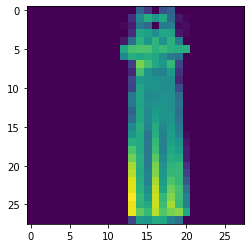

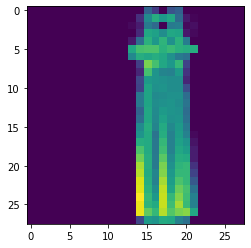

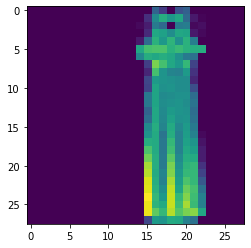

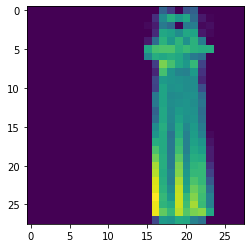

In [6]:
ix = 250 # Call a random image in the dataset and produce multiple images by trasnlating 
preds = []
for px in range(-5,6):
  img = trn_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1) #Roll the image column-wise
  plt.imshow(img2)
  plt.show()
  img3 = torch.Tensor(img2).view(28*28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

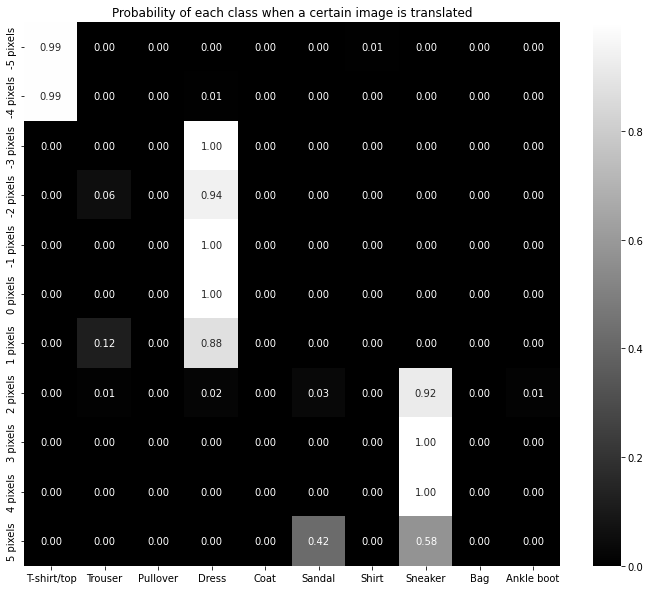

In [7]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class when a certain image is translated')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

# **3. Implementation of CNN**

In [8]:
class FMNISTds(Dataset):
  def __init__(self,x,y):
    x = x.float()
    x = x.view(-1,1,28,28)/255
    self.x, self.y = x, y
  def __len__(self): return len(self.x)
  def __getitem__(self,ix):
    x = self.x[ix]
    y = self.y[ix]
    return x.to(device), y.to(device)

def get_model():
  model = nn.Sequential(
      nn.Conv2d(1,64,kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(64,128,kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(3200,256),
      nn.ReLU(),
      nn.Linear(256,10)
  ).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
  return model, loss_fn, optimizer

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [9]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.5,patience=0,
                                                       threshold=0.001,
                                                       verbose=True,
                                                       min_lr=1e-5,
                                                       threshold_mode='abs')
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
  print(f'{epoch+1}/10 in pregress')
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x,y,model,loss_fn,optimizer)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
 
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    trn_acc = accuracy(x,y,model)
    train_epoch_accuracies.extend(trn_acc)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
 
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_acc = accuracy(x,y,model)
    validation_loss = val_loss(x,y,model,loss_fn)
    scheduler.step(validation_loss)

  val_epoch_accuracy = np.mean(val_acc)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

1/10 in pregress
2/10 in pregress
3/10 in pregress
4/10 in pregress
5/10 in pregress
Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
6/10 in pregress
7/10 in pregress
Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
8/10 in pregress
Epoch 00008: reducing learning rate of group 0 to 1.2500e-04.
9/10 in pregress
Epoch 00009: reducing learning rate of group 0 to 6.2500e-05.
10/10 in pregress
Epoch 00010: reducing learning rate of group 0 to 3.1250e-05.


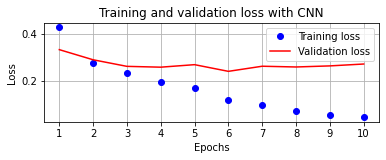

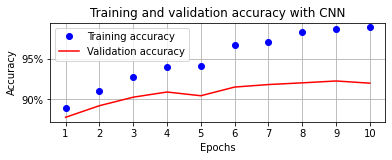

In [10]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

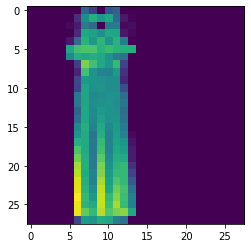

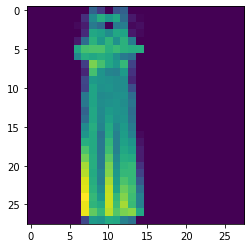

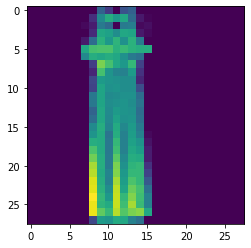

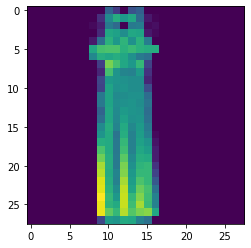

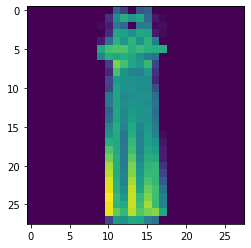

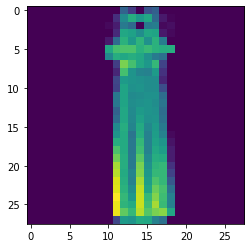

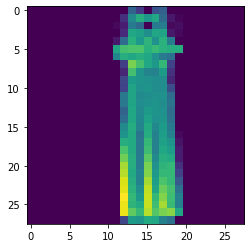

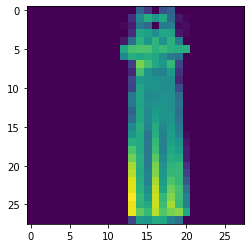

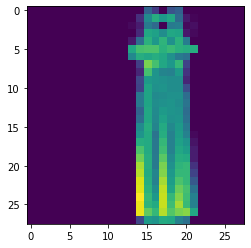

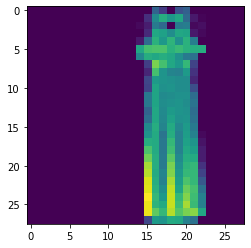

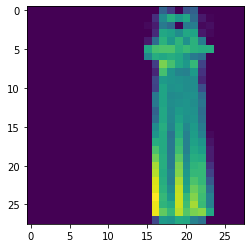

In [11]:
ix = 250 # Call a random image in the dataset and produce multiple images by trasnlating 
preds = []
for px in range(-5,6):
  img = trn_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1) #Roll the image column-wise
  plt.imshow(img2)
  plt.show()
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

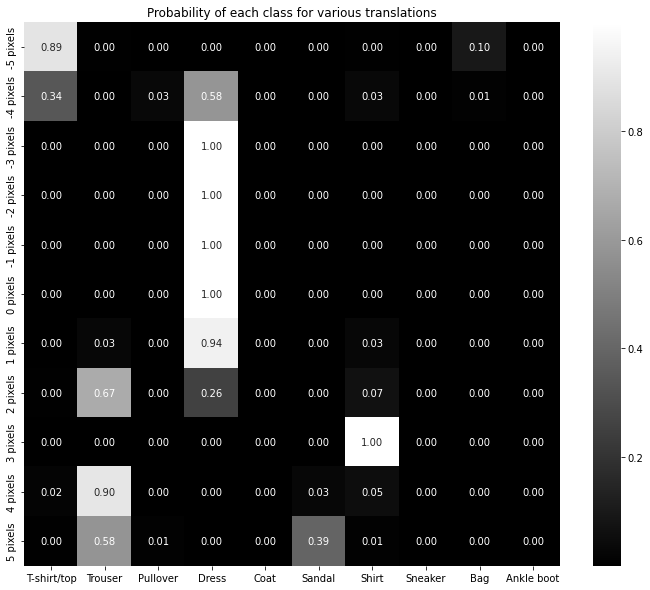

In [12]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

# **4. Image Augmentation**

In [80]:
!pip install -U imgaug
import imgaug.augmenters as iaa

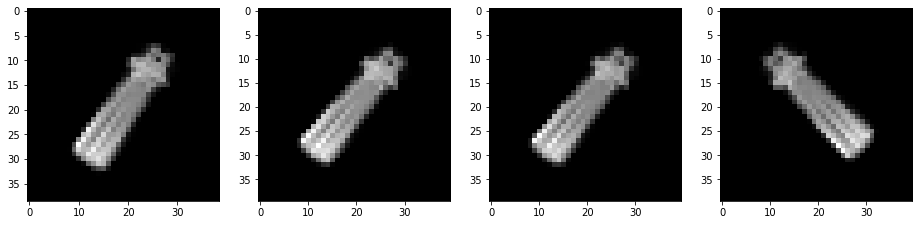

In [81]:
def to_numpy(tensor):
  return tensor.cpu().detach().numpy()

plt.figure(figsize=(20,20))
plt.subplot(151)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(trn_images[ix])), cmap='gray')
plt.subplot(152)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(trn_images[ix])), cmap='gray')
plt.subplot(153)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(trn_images[ix])), cmap='gray')
plt.subplot(154)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(trn_images[ix])), cmap='gray')

Text(0.5, 1.0, 'Random 20% salt and pepper noise')

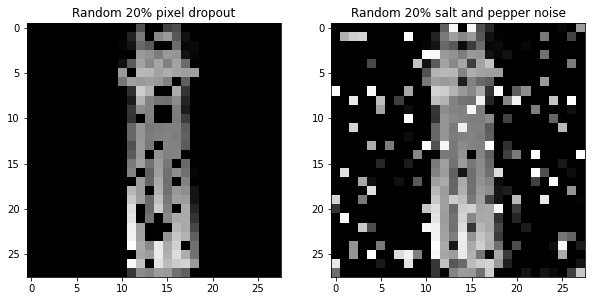

In [82]:
plt.figure(figsize=(10,10))
plt.subplot(121)
aug = iaa.Dropout(p=0.2,)
plt.imshow(aug.augment_image(to_numpy(trn_images[ix])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Random 20% pixel dropout')
plt.subplot(122)
aug = iaa.SaltAndPepper(0.2,)
plt.imshow(aug.augment_image(to_numpy(trn_images[ix])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Random 20% salt and pepper noise')

Text(0.5, 1.0, 'Gaussian blurring of image\n with a sigma of 1')

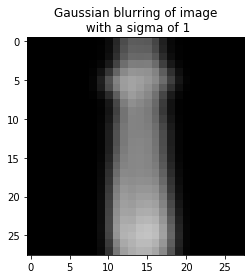

In [83]:
aug = iaa.GaussianBlur(sigma=1)
plt.imshow(aug.augment_image(to_numpy(trn_images[ix])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Gaussian blurring of image\n with a sigma of 1')

Text(0.5, 1.0, 'Image augmented using a \nrandom orderof the two augmentations')

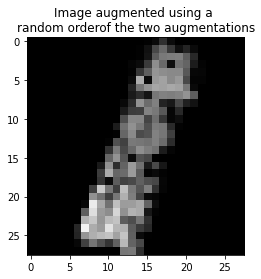

In [84]:
seq = iaa.Sequential([
      iaa.Dropout(p=0.2,),
    iaa.Affine(rotate=(-30,30))], random_order= True)

plt.imshow(seq.augment_image(to_numpy(trn_images[ix])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Image augmented using a \nrandom orderof the two augmentations')

In [7]:
from torchvision import datasets
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_folder = '/content/' # This can be any directory
# you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, 
                               download=True,
                               train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder, 
                                   download=True,
                                   train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [8]:
from imgaug import augmenters as iaa
aug = iaa.Sequential([
    iaa.Affine(translate_px={'x':(-10,10)},
        mode='constant')
])

In [9]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
      self.x, self.y = x, y
      self.aug = aug
    def __getitem__(self, ix):
      x, y = self.x[ix], self.y[ix]
      return x, y
    def __len__(self): return len(self.x)
    def collate_fn(self, batch):
        ims, classes = list(zip(*batch))
        if self.aug: ims=self.aug.augment_images(images=ims)
        ims = torch.tensor(ims)[:,None,:,:].to(device)/255.
        classes = torch.tensor(classes).to(device)
        return ims, classes

In [11]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [12]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [15]:
def get_dataset():
  train = FMNISTDataset(tr_images, tr_targets, aug=aug)
  trn_dl = DataLoader(train, batch_size=64,collate_fn=train.collate_fn, shuffle=True,drop_last=True)
  val = FMNISTDataset(val_images, val_targets, aug=aug)
  val_dl = DataLoader(val, batch_size=len(val_images),collate_fn=val.collate_fn, shuffle=True)
  return trn_dl, val_dl
trn_dl, val_dl = get_dataset()
model, loss_fn, optimizer = get_model()

In [17]:
for epoch in range(5):
    print(epoch+1)
    for _, batch in enumerate(iter(trn_dl)):
      x, y = batch
      batch_loss = train_batch(x, y, model, optimizer, loss_fn)

1
2
3
4
5


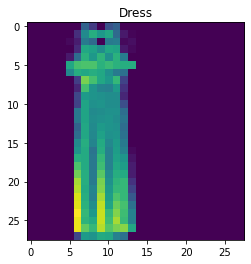

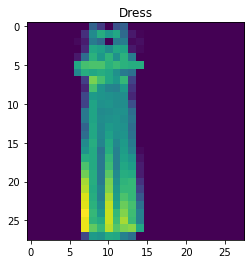

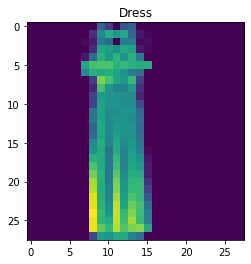

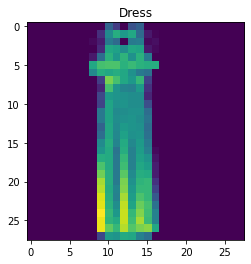

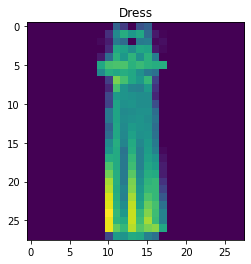

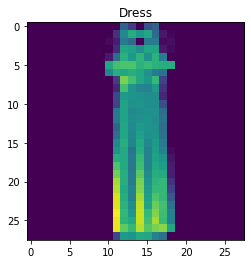

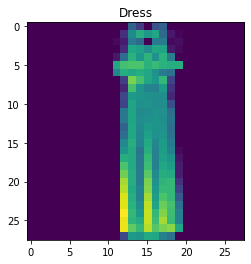

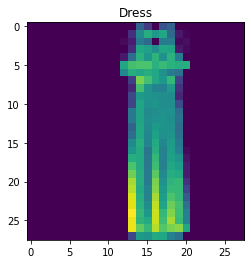

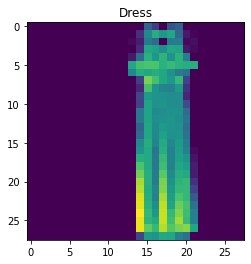

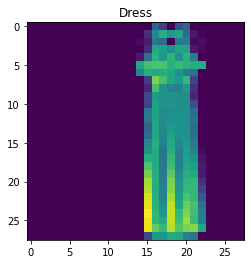

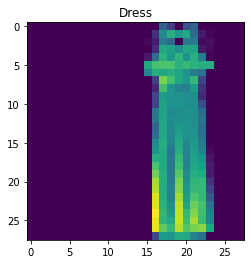

In [18]:
preds = []
ix = 250
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()

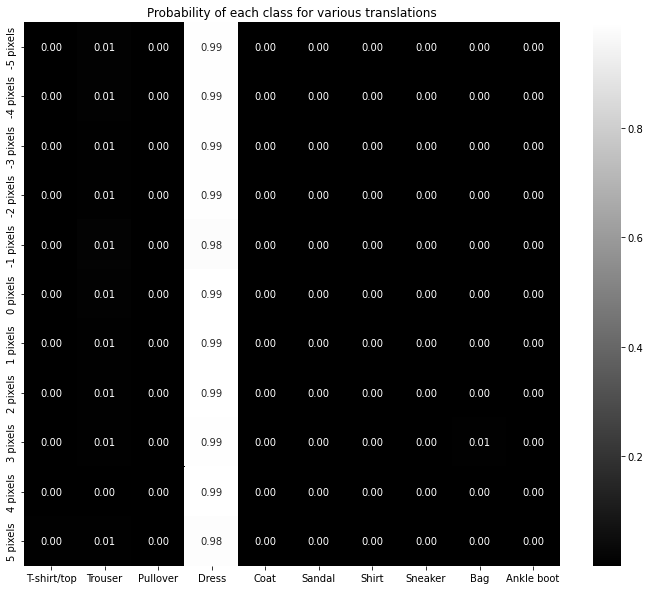

In [19]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')